# **pipeline2: pretrained cnn features**

In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

#method 1: pretrained cnn -- used for knn, logistic reg, svm, nn and ensemble method training
# Load pre-trained ResNet model (without classification head)
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final classification layer
model.eval()  # Set to evaluation mode

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# **Preprocessing**

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv2
import os as os
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


# Define folder paths for pleasant and unpleasant images
pleasant_path = "/kaggle/input/mldata/train-images/train/pleasant" 
unpleasant_path = "/kaggle/input/mldata/train-images/train/unpleasant" 
test_path = "/kaggle/input/mldata/TEST_images/TEST_images"

# List to store image data
image_data1 = []
image_data2 = []

test_data = []

# Process Pleasant Images
for filename in sorted(os.listdir(pleasant_path)):
    if filename.endswith(".jpg"):
        image_data1.append([filename, 1])

# Process Unpleasant Images
for filename in sorted(os.listdir(unpleasant_path)):
    if filename.endswith(".jpg"):
        image_data2.append([filename, 0])

# Process test images
for filename in sorted(os.listdir(test_path)):
    if filename.endswith(".jpg"):
        test_data.append([filename, 0]) #defaults to unpleasant label (0)

# Create DataFrame
df1 = pd.DataFrame(image_data1, columns=["Filename", "Label"])
df2 = pd.DataFrame(image_data2, columns=["Filename", "Label"])
df3 = pd.DataFrame(test_data, columns=["Filename", "Label"])

#df1.head()
#df2.head()

# show info for all files (count,freq,unique)
print(df1.describe())
print(df2.describe())

# Save to CSV
df1.to_csv("pleasant_labels.csv", index=False)
df2.to_csv("unpleasant_labels.csv", index=False)

# Image transformations (match what ResNet expects)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


labels_df = pd.concat([df1, df2], ignore_index=True)
labels_df.to_csv("test.csv",index=False)

image_features = []
labels = []
pleasant = pleasant_path
print(pleasant)
unpleasant = unpleasant_path
print(unpleasant)

#(1)
# Process each image and get its assigned label
for _, row in labels_df.iterrows():
    
    label = row["Label"]
    filename = os.path.basename(row["Filename"])

    if(label == 1):
        img_path = pleasant+"/"+filename
    elif(label == 0):
        img_path = unpleasant+"/"+filename
    
    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  

        # Extract features
    with torch.no_grad():
        features = model(img)

    features = features.view(-1).numpy()  # Flatten feature vector

        # Store features & label
    image_features.append(features)
    labels.append(label)

# Convert to DataFrame

df = pd.DataFrame(image_features)
df["Label"] = labels # labels are the targets
df = df.dropna()
# Save features to CSV
df.to_csv("extracted_features_pytorch.csv", index=False)

# Display first few rows
df.head()
print(df.describe())




        Label
count  3394.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
        Label
count  2982.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
/kaggle/input/mldata/train-images/train/pleasant
/kaggle/input/mldata/train-images/train/unpleasant
                 0            1            2            3            4  \
count  6376.000000  6376.000000  6376.000000  6376.000000  6376.000000   
mean      1.037109     0.967149     0.638987     0.385116     0.194197   
std       0.925935     0.695186     0.489925     0.444327     0.334713   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.317917     0.428816     0.247054     0.054434     0.000000   
50%       0.828909     0.864022     0.548567     0.231676     0.056586   
75%       1.517249     1.359889     0.926566     0.574220     0.253121   
max       8.048038     4.439513     3.104102     4.86778

In [13]:
df1.head()

,Filename,Label
0,0001.jpg,1
1,0003.jpg,1
2,0004.jpg,1
3,0005.jpg,1
4,0006.jpg,1


In [23]:
image_features2 = []
labels2 = []

# Image transformations (match what ResNet expects)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


df3.to_csv("test2.csv",index=False)
#(1)
# Process each image and get its assigned label
for _, row in df3.iterrows():
    
    label = row["Label"]
    filename = os.path.basename(row["Filename"])

    img_path = test_path+"/"+filename
  

    if img_path is None: #testing
         print(f"Warning: {filename} not found in any folder!")
         continue

    # print(f"Processing: {img_path} with label {label}") #debugging
    
    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Extract features
    with torch.no_grad():
        features = model(img)

    features = features.view(-1).numpy()  # Flatten feature vector

    # Store features & label
    image_features2.append(features)
    labels2.append(label)

# Convert to DataFrame
dft = pd.DataFrame(image_features2)
dft["Label"] = labels2 # so basically labels are the targets
dft = dft.dropna()
# Save features to CSV
dft.to_csv("extracted_features_test.csv", index=False)

# Display first few rows
dft.head()
print(dft.describe())

                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.860674    0.902956    0.523201    0.440588    0.183024    0.059722   
std      0.853038    0.620695    0.455326    0.419144    0.328577    0.134583   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.235976    0.472536    0.157970    0.086018    0.000000    0.000000   
50%      0.613670    0.826333    0.410429    0.350819    0.059651    0.000000   
75%      1.257543    1.221832    0.777885    0.684779    0.238664    0.051070   
max      5.868658    4.633618    2.644980    2.094131    3.181099    1.016616   

                6           7           8           9  ...         503  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.556628    0.924162    0.433826    0.220170  ...    0.521034   
std      0.681238    0.593217    0.360973    0.3

# **Heatmap**

features shape: (6376, 512)


<ipython-input-6-b686feca8fbc>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_scaled["label"] = labels


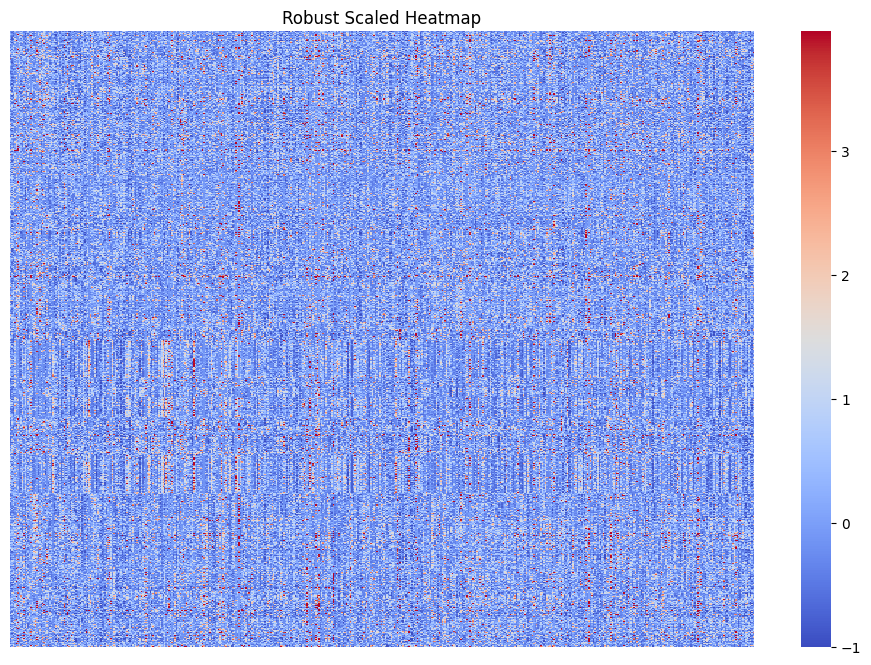

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler

# Use your original DataFrame
features = df.iloc[:, :-1]  # exclude label column
labels = df.iloc[:, -1]     # label column

# Make sure features is a 2D DataFrame
print("features shape:", features.shape)  # Should be (6376, 512)

# Scale features
scaler = RobustScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# Clip extreme values (99th percentile)
percentile_99 = np.percentile(features_scaled, 99)
percentile_1 = np.percentile(features_scaled, 1)
features_scaled = np.clip(features_scaled, percentile_1, percentile_99)
# Sort by labels
features_scaled["label"] = labels
features_sorted = features_scaled.sort_values(by="label").drop(columns=["label"])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(features_sorted, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Robust Scaled Heatmap")
plt.show()

# **train-test set split**

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split features (X) and labels (y)
X = df.iloc[:, :-1]  # Features after preprocessing
y = df.iloc[:, -1]  # Corresponding labels

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

l = LabelEncoder()
y_train_enc = l.fit_transform(y_train)
y_test_enc = l.fit_transform(y_test)
i =0
while(i<5):
    print(y_train_enc[i]) #head() but for this particular array lol
    i+=1

X_train.head()

0
1
0
0
0


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
6104,0.402714,1.739063,0.663276,0.257356,0.011995,0.000000,1.565654,0.761460,0.026875,0.341429,...,0.777410,1.556759,0.640036,1.062188,2.230688,2.446000,0.182155,0.255100,1.402906,1.854060
471,4.375042,0.521773,0.888456,0.173105,0.000000,0.000000,0.386299,0.547178,1.379966,0.017057,...,0.455682,0.856355,1.740450,1.429711,1.614609,1.118637,1.536667,0.913240,2.018157,1.510094
3403,0.275311,0.240086,0.106592,0.365001,0.131254,0.000000,0.149943,0.219451,0.495560,0.000000,...,0.931596,0.000000,0.365063,0.044592,1.862165,0.752278,1.228202,1.247397,3.470768,0.274406
4599,0.240820,0.990320,0.544547,0.171202,0.607444,0.012189,0.339088,0.396856,0.131857,0.108812,...,0.561517,0.564309,0.470085,0.799523,1.686352,0.862453,0.025964,0.461465,2.337654,0.000000
5094,1.330917,0.364007,0.721377,0.029708,0.059459,0.000000,0.559343,0.617969,0.231106,0.062331,...,0.519341,0.000000,1.407852,0.761262,0.239684,1.242871,0.407257,1.314393,3.292071,0.422877


# **evaluation method**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


def compute_metrics(model,X_train,y_train):
    score = model.score(X_train, y_train)
    print(score*100)
    y_pred = model.predict(X_train)
    # Metrics
    print(classification_report(y_train, y_pred))
    

    f1 = f1_score(y_train, y_pred)
    print("F1 Score:", f1)
    cm = confusion_matrix(y_train, y_pred)
    print(confusion_matrix(y_train, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    y_proba = model.predict_proba(X_train)[:, 1]  # probs for class 1

    if hasattr(model, "predict_proba"):
        preds = model.predict_proba(X_train)
        preds = preds[:, 1] if preds.shape[1] > 1 else preds  # binary case
    else:
        raise ValueError("Model does not support predict_proba.")

    
    mse = mean_squared_error(y_train, preds)
    print("Mean squared error:",mse)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# ROC Curve
    RocCurveDisplay.from_estimator(model, X_train, y_train, ax=axes[0])
    axes[0].set_title("ROC Curve")

# Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=axes[1])
    axes[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, feature_indices=(0, 1), resolution=0.02):

    # Select only the two features to plot
    x1_index, x2_index = feature_indices
    x1_min, x1_max = X[:, x1_index].min() - 1, X[:, x1_index].max() + 1
    x2_min, x2_max = X[:, x2_index].min() - 1, X[:, x2_index].max() + 1

    # Create grid
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    grid_2d = np.c_[xx1.ravel(), xx2.ravel()]

    # Prepare full feature input with fixed values for other dimensions
    n_features = X.shape[1]
    X_full = np.zeros((grid_2d.shape[0], n_features))
    X_full[:, x1_index] = grid_2d[:, 0]
    X_full[:, x2_index] = grid_2d[:, 1]

    # Predict over the grid
    Z = classifier.predict(X_full)
    Z = Z.reshape(xx1.shape)

    # Plot decision surface
    cmap = ListedColormap(('red', 'blue', 'lightgreen', 'gray'))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot actual data points (only the two selected features)
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, x1_index],
            y=X[y == cl, x2_index],
            alpha=0.8,
            c=cmap(idx),
            marker='o',
            label=f'Class {cl}'
        )

    plt.xlabel(f'Feature {x1_index}')
    plt.ylabel(f'Feature {x2_index}')
    plt.legend()
    plt.title("Decision Regions")
    plt.show()


# **model training**

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

param_grid = {
        'n_neighbors': [2, 4, 6, 8, 10],  # Number of neighbors
        'metric': ['cosine', 'euclidean'],  # Distance metric
    }

def hyperparameter_tuning(X_train, y_train,param_grid,model, scoring_metric='accuracy'): 
    
    
    rand_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=40,
                                    cv=5, scoring='accuracy', n_jobs=-1,
                                    verbose=1, random_state=True)
    rand_search.fit(X_train,y_train)

    
    # saves all tried parameters and scores to csv file
    results_df = pd.DataFrame(rand_search.cv_results_)

    print(results_df['mean_test_score'].describe())
    
    results_df.to_csv("hyperparameters.csv", index=False)
    print("Grid search results saved to hyperparameters.csv")


    return rand_search.best_params_, rand_search.best_score_,rand_search.cv_results_,rand_search.best_estimator_


# **plot functions**

In [27]:
def plot_knn(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__n_neighbors',
        y='mean_test_score',
        hue='param_model__metric',
        marker='o'
    )
    plt.title('KNN - Accuracy vs. n_neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.legend(title='Metric')
    plt.show()

def plot_logistic_regression(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__C',
        y='mean_test_score',
        marker='o'
    )
    plt.title('Logistic Regression - Accuracy vs. C')
    plt.xlabel('Inverse Regularization Strength (C)')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.show()
    
def plot_random_forest(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__n_estimators',
        y='mean_test_score',
        hue='param_model__max_depth',
        marker='o'
    )
    plt.title('Random Forest - Accuracy vs. n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.legend(title='Max Depth')
    plt.show()

def plot_bagging_svm(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__n_estimators',
        y='mean_test_score',
        hue='param_model__max_samples',
        marker='o'
    )
    plt.title('Bagging SVM - Accuracy vs. n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.legend(title='Max Samples')
    plt.show()

def plot_adaboost(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__n_estimators',
        y='mean_test_score',
        hue='param_model__learning_rate',
        marker='o'
    )
    plt.title('AdaBoost - Accuracy vs. n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.legend(title='Learning Rate')
    plt.show()

def plot_svm(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__C',
        y='mean_test_score',
        marker='o'
    )
    plt.title('SVM - Accuracy vs. C')
    plt.xlabel('Regularization Parameter (C)')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.show()

def plot_neural_net(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='param_model__learning_rate_init',
        y='mean_test_score',
        hue='param_model__solver',
        marker='o'
    )
    plt.title('Neural Net - Accuracy vs. Learning Rate Init')
    plt.xlabel('Learning Rate Initialization')
    plt.ylabel('Mean CV Accuracy')
    plt.grid(True)
    plt.legend(title='Solver')
    plt.show()



 Running: StandardScaler + KNN
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=40. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


count    10.000000
mean      0.849686
std       0.017401
min       0.812353
25%       0.842647
50%       0.846765
75%       0.865441
max       0.869216
Name: mean_test_score, dtype: float64
Grid search results saved to hyperparameters.csv

Best KNN parameters: {'model__n_neighbors': 10, 'model__metric': 'cosine'}
89.68627450980392
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2389
           1       0.92      0.88      0.90      2711

    accuracy                           0.90      5100
   macro avg       0.90      0.90      0.90      5100
weighted avg       0.90      0.90      0.90      5100

F1 Score: 0.9007172517931294
[[2188  201]
 [ 325 2386]]
Mean squared error: 0.07556274509803922


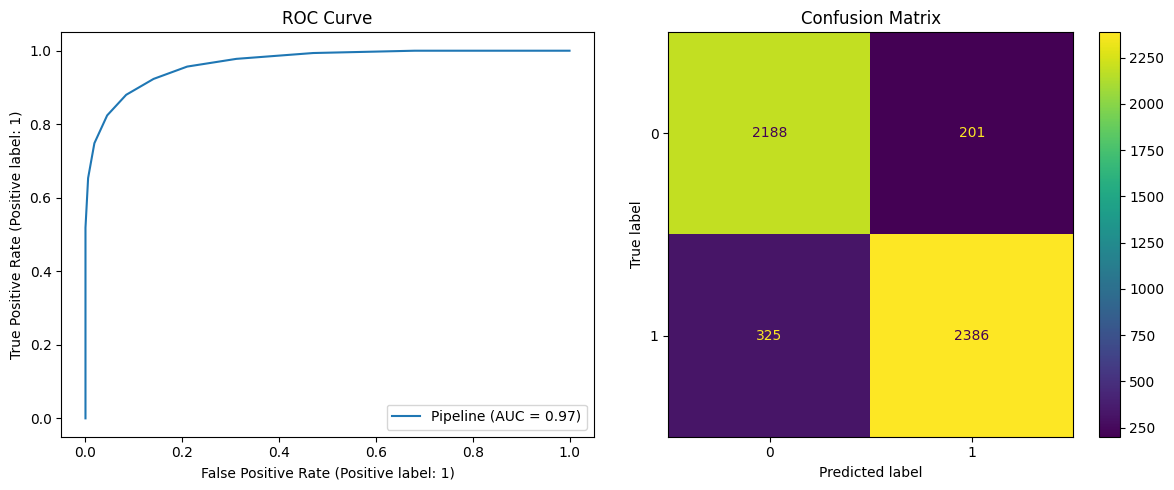

86.83385579937304
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       593
           1       0.90      0.84      0.87       683

    accuracy                           0.87      1276
   macro avg       0.87      0.87      0.87      1276
weighted avg       0.87      0.87      0.87      1276

F1 Score: 0.8729198184568836
[[531  62]
 [106 577]]
Mean squared error: 0.09344043887147335


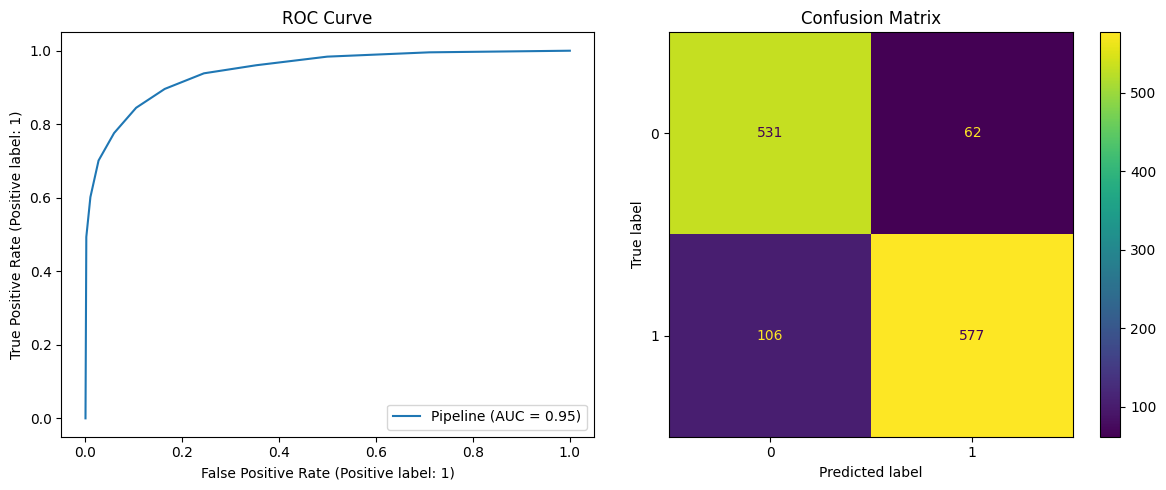

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

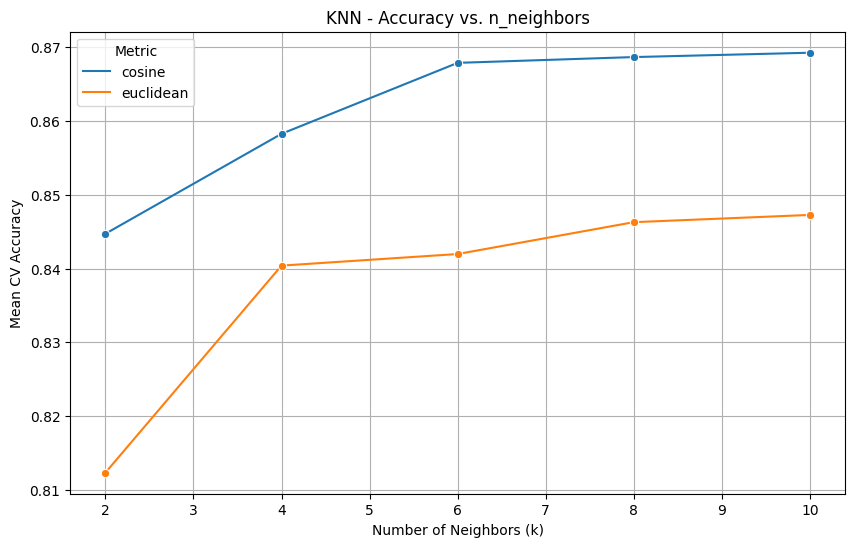

In [28]:
### from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from itertools import product

layer_sizes = [(h,) for h in [512, 256, 128, 64]] + \
              [(h1, h2) for h1, h2 in product([512, 256, 128, 64], repeat=2)] + \
              [(512, 256, 128), (256, 128, 64), (512, 256, 128, 64)]

activation_functions = ['relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'sgd']

base_svc = LinearSVC()

base_tree = DecisionTreeClassifier(max_depth=1)

scalers = {
    'StandardScaler': StandardScaler(),
    #'MinMaxScaler': MinMaxScaler(),
    #'RobustScaler': RobustScaler(),
    #'Normalizer': Normalizer()
}

models = {
    'KNN': (KNeighborsClassifier(), {
        'model__n_neighbors': [2, 4, 6, 8, 10],
        'model__metric': ['cosine', 'euclidean']
    }),
    # 'LogisticRegression': (LogisticRegression(max_iter=1000), {
    #     'model__C': [0.1, 1, 10]
    # }),
    # 'RandomForestClassifier': (RandomForestClassifier(), {
    #     'model__n_estimators': [50, 100, 200],
    #     'model__max_depth': [None, 10, 20, 30]
    # }),
    # 'BaggingSVM': (BaggingClassifier(base_estimator=base_svc), {
    #     'model__n_estimators': [10, 15, 20],
    #     'model__max_samples': [0.8, 1.0],
    #     'model__bootstrap': [True]
    # }),
    # 'AdaBoost': (AdaBoostClassifier(base_estimator=base_tree), {
    #     'model__n_estimators': [100, 150, 200],
    #     'model__learning_rate': [0.5, 1.0]
    # }),
    # 'SVM': (SVC(probability=True), {
    #     'model__C': [0.1, 1, 10,100],
    #     'model__kernel': ['linear','rbf']
    # }),
    # 'NeuralNet': (MLPClassifier(max_iter=1000,early_stopping=True), {
    #     'model__hidden_layer_sizes': layer_sizes,
    #     'model__activation': activation_functions,
    #     'model__solver': optimizers,
    #     'model__alpha': [0.0001, 0.001],  # Regularization
    #     'model__learning_rate_init': [0.001, 0.01],
    # })
}

results_all = []
best_models = []

for scaler_name, scaler in scalers.items():
    for model_name, (model, param_grid) in models.items():
        print(f"\n Running: {scaler_name} + {model_name}")

        # Create pipeline
        pipeline = Pipeline([('scaler', scaler), ('model', model)  ])

        # Use hyperparameter_tuning function
        best_params, best_score, cv_results, best_model = hyperparameter_tuning(
            X_train, y_train,
            param_grid=param_grid,
            model=pipeline,
            scoring_metric='f1'
        )

        results_df = pd.DataFrame(cv_results)

        print(f"\nBest {model_name} parameters: {best_params}")
        compute_metrics(best_model,X_train,y_train)
        compute_metrics(best_model,X_test,y_test)
        best_models.append([best_model,best_params,best_score])

        fitted_model = best_model.named_steps['model']

        if(model_name == 'RandomForestClassifier' or model_name == 'AdaBoost'):
            print(len(fitted_model.estimators_))  # Number of individual trees
            # Print depth of each tree
            for i, tree in enumerate(fitted_model.estimators_[:5]):
                print(f"Tree {i}: depth={tree.tree_.max_depth}, leaves={tree.tree_.n_leaves}")

        if model_name == "KNN":
            plot_knn(results_df)
        elif model_name == "LogisticRegression":
            plot_logistic_regression(results_df)
        elif model_name == "RandomForestClassifier":
            plot_random_forest(results_df)
        elif model_name == "BaggingSVM":
            plot_bagging_svm(results_df)
        elif model_name == "AdaBoost":
            plot_adaboost(results_df)
        elif model_name == "SVM":
            plot_svm(results_df)
        elif model_name == "NeuralNet":
            plot_neural_net(results_df)
        

        results_all.append({ #prolly not needed
            'Scaler': scaler_name,
            'Model': model_name,
            'Best Score': best_score,
            'Best Params': best_params,
            'Results': cv_results
        })
max_score = 0
best_scores = []
#best_scores = [model[2] for model in best_models]
for model in best_models:
    best_scores.append(model[2])

max_score = max(best_scores)

best_idx=0
for model in best_models:
    best_idx += 1
    if model[2] == max_score:
        break
best_model2 = best_models[best_idx-1][0]

# **pipeline1:  CNN directly on the images**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def load_images(filenames, base_dir):
    images = []
    for fname in filenames:
        path = os.path.join(base_dir, fname)
        img = Image.open(path).convert('RGB')
        images.append(np.array(img))
    return images  # <- keep it a list, not np.array

# Load training data
X_train_pleasant = load_images(df1['Filename'].values, '/kaggle/input/mldata/train-images/train/pleasant')
X_train_unpleasant = load_images(df2['Filename'].values, '/kaggle/input/mldata/train-images/train/unpleasant')
X_train = np.concatenate([X_train_pleasant, X_train_unpleasant])
y_train = np.concatenate([np.zeros(len(df1)), np.ones(len(df2))])

# Load test data
X_test = load_images(X_test, '/kaggle/input/mldata/TEST_images/TEST_images')
# y_test is assumed to already be a 1D NumPy array


class NumpyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.resize = transforms.Resize((64, 64))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_data = self.images[idx]

        # Convert raw numpy image to PIL image
        if not isinstance(img_data, np.ndarray):
            raise TypeError(f"Expected np.ndarray but got {type(img_data)}")
        img = Image.fromarray(img_data.astype('uint8'), 'RGB')
        img = self.resize(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

class ImageArrayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.resize = transforms.Resize((64, 64))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_data = self.images[idx]

        if isinstance(img_data, np.ndarray):
            # Validate array shape
            if img_data.ndim != 3 or img_data.shape[2] != 3:
                raise ValueError(f"Expected image shape (H, W, 3), got {img_data.shape}")
            img = Image.fromarray(img_data.astype('uint8'), 'RGB')
        else:
            raise TypeError(f"Expected image data as ndarray, got {type(img_data)}")

        img = self.resize(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and loaders
train_dataset = NumpyImageDataset(X_train, y_train, transform=transform)
test_dataset = NumpyImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

class CNNModel(nn.Module):
    def __init__(self, num_conv_layers=3, num_fc_layers=2, num_classes=2):
        super().__init__()

        assert 2 <= num_conv_layers <= 5
        assert 1 <= num_fc_layers <= 3

        # conv blocks
        in_ch = 3
        conv_chs = [32, 64, 128, 256, 512]
        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()
        for i in range(num_conv_layers):
            out_ch = conv_chs[i]
            self.convs.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            self.bns.append(nn.BatchNorm2d(out_ch))
            in_ch = out_ch
        self.pool = nn.MaxPool2d(2,2)

        # Global average pooling → always (batch, last_out_ch, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # FC Head
        last_ch = conv_chs[num_conv_layers-1]
        fc_layers = []
        # first FC
        fc_layers.append(nn.Linear(last_ch, 128))
        if num_fc_layers >= 2:
            fc_layers.append(nn.Linear(128, 64))
        # final classification
        fc_layers.append(nn.Linear(64 if num_fc_layers>=2 else 128, num_classes))
        self.fcs = nn.ModuleList(fc_layers)

    def forward(self, x):
        # Conv→BN→ReLU→Pool blocks
        for conv, bn in zip(self.convs, self.bns):
            x = self.pool(F.relu(bn(conv(x))))
        # Global pooling & flatten
        x = self.global_pool(x)          # → (B, C, 1, 1)
        x = x.view(x.size(0), -1)        # → (B, C)

        # FC layers
        for i, fc in enumerate(self.fcs):
            x = fc(x) if i == len(self.fcs)-1 else F.relu(fc(x))

        return x




from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_and_evaluate(model, train_loader, test_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            running_corrects += (preds == labels).sum().item()

        train_acc = running_corrects / total
        print(f"Epoch {epoch+1} | Loss: {running_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # === Evaluation ===
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pleasant", "Unpleasant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return train_acc, test_acc


# ========== EXPERIMENT LOOP ==========
results = []
conv_options = [2, 3, 4]   # You can add 5 if training time is okay
fc_options = [1, 2]

for num_conv in conv_options:
    for num_fc in fc_options:
        print(f"\nTraining model with {num_conv} conv layers and {num_fc} FC layers")

        model = CNNModel(num_conv_layers=num_conv, num_fc_layers=num_fc, num_classes=2)
        train_acc, test_acc = train_and_evaluate(model, train_loader, test_loader, epochs=5)

        results.append({
            "Conv Layers": num_conv,
            "FC Layers": num_fc,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc
        })

# ========== SUMMARY ==========
print("\nSummary of All Experiments:")
for r in results:
    print(f"Conv: {r['Conv Layers']}, FC: {r['FC Layers']}, Train Acc: {r['Train Accuracy']:.4f}, Test Acc: {r['Test Accuracy']:.4f}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3394,) + inhomogeneous part.

# **pipeline1 final training**

In [12]:
import csv

model.eval()  # Set model to evaluation mode
all_preds = []

print(df1.columns)
print(df2.columns)
print(type(X_train))
print(X_train[:5])


with torch.no_grad():
    for images, _ in test_loader:  # ignore labels during prediction
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())  # if using GPU, move to CPU

for fname, pred in zip(X_test, all_preds):
    label = "pleasant" if pred == 1 else "unpleasant"
    print(f"{fname} => Predicted: {label}")

unknown_pics = pd.read_csv('/kaggle/input/mldata/Test-IDs.csv')
size = y_pred_u.size

pics_unordered = df3["Filename"].tolist()
pics_ordered = unknown_pics["Filename"].tolist()


unordered_map = {filename: index for index, filename in enumerate(pics_unordered)}

# Initialize the sorted_labels array with zero values.
sorted_labels = [0] * size
# Loop over each entry in pics_ordered and assign the corresponding y_pred_u value to the sorted_labels.
for idx, filename in enumerate(pics_ordered):
    # Find the index of the current filename in pics_unordered using the unordered_map.
    unordered_index = unordered_map[filename]
    
    # Place the predicted label in the correct position of sorted_labels.
    sorted_labels[unordered_index] = y_pred_u[idx]

for i in range(size):
    if sorted_labels[i] == 0:
        sorted_labels[i] = "0"
id_list = [i for i in range(size)]

with open('output_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',')  # Ensure delimiter is a comma
    
    # Write the header first
    writer.writerow(['ID', 'label'])
    
    # Write the ID and label pairs, explicitly converting values to strings
    for i in range(len(id_list)):
        writer.writerow([id_list[i], str(sorted_labels[i])])  # Convert to string


Index(['Filename', 'Label'], dtype='object')
Index(['Filename', 'Label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
           0         1         2         3         4         5         6    \
6104  0.402714  1.739063  0.663276  0.257356  0.011995  0.000000  1.565654   
471   4.375042  0.521774  0.888455  0.173105  0.000000  0.000000  0.386299   
3403  0.275311  0.240086  0.106592  0.365001  0.131254  0.000000  0.149944   
4599  0.240820  0.990320  0.544547  0.171202  0.607444  0.012189  0.339088   
5094  1.330917  0.364007  0.721376  0.029707  0.059459  0.000000  0.559343   

           7         8         9    ...       502       503       504  \
6104  0.761460  0.026875  0.341429  ...  0.777411  1.556758  0.640036   
471   0.547178  1.379966  0.017057  ...  0.455681  0.856355  1.740449   
3403  0.219451  0.495560  0.000000  ...  0.931596  0.000000  0.365063   
4599  0.396856  0.131857  0.108812  ...  0.561517  0.564309  0.470084   
5094  0.617969  0.231106  0.062331  ..

NameError: name 'test_loader' is not defined

# **pipelne2 final training**

In [29]:
import csv

X_unknown = dft.iloc[:, :-1] #aligned with df3a

y_pred_u = best_model2.predict(X_unknown)


unknown_pics = pd.read_csv('/kaggle/input/mldata/Test-IDs.csv')
size = y_pred_u.size

pics_unordered = df3["Filename"].tolist()
pics_ordered = unknown_pics["Filename"].tolist()

unordered_map = {filename: index for index, filename in enumerate(pics_unordered)}

# Initialize the sorted_labels array with zero values.
sorted_labels = [0] * size

pics_unordered_norm = [p.strip().lower() for p in df3["Filename"].tolist()]
pics_ordered_norm = [p.strip().lower() for p in unknown_pics["Filename"].tolist()]

# Loop over each entry in pics_ordered and assign the corresponding y_pred_u value to the sorted_labels.
for idx, filename in enumerate(pics_ordered):

    unordered_index = unordered_map[filename]
    
    sorted_labels[unordered_index] = y_pred_u[idx]

for i in range(size):
    if sorted_labels[i] == 0:
        sorted_labels[i] = "0"
id_list = [i for i in range(size)]

with open('output_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',')  # delimiter is a comma
    
    writer.writerow(['ID', 'label'])
    
    for i in range(len(id_list)):
        writer.writerow([id_list[i], str(sorted_labels[i])])  # Convert to string


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))